In [31]:
# Custom Modules import
from util.data_loader import load_competitions, load_matches
from util.team_strength_team_stats import calculate_team_stats, calculate_chances_from_played_games, create_test_dataset_entry_based_on_certain_matchweeks, generate_dataset, create_home_away_pairs
from statsbombpy import sb
from statsbombpy.api_client import NoAuthWarning

import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore', category=NoAuthWarning)



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay



%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Nuanced Team Strength Model

### Legend:  
🔴- to do <br>
🟠- in progress <br>
🟢- done <br>


### Used Features to quantify Team Strength:
- 🔴 Possession
- 🟢 Shots on Goal/ 🔴 on Target
- 🟢 Goals 
- 🔴 Goals_conceded
- 🟢 Passes 
- 🟠 Duels


### Other Features used to predict Match Outcomes:
- 🔴 Last 5 matches
- 🟢 Starting XI
- 🔴 Stakes of the match 
- 🔴 Injured/Penalized players


### Output Predictions
- 🔴 Label of Match Status for Home Team
- 🔴 Betting Odds for both Home and Away Team

### Trainings/Test Daten
<br>


### Prior Baseline (Aus Literatur Outcome Prediction Modelle anschauen)


# Event Types, etc.

In [2]:
# Load data
matches = load_matches(competition_id=9, season_id=27)

test_event = sb.events(match_id=3890259)
test_event.shape

print('------------distinct_types----------------')
print(test_event['type'].unique())
print('------------pass_outcome----------------')
print(test_event['pass_outcome'].unique())
print('------------pass_type-------------')
print(test_event['pass_type'].unique())
print('------------pass_height----------------')
print(test_event['pass_height'].unique())

------------distinct_types----------------
['Starting XI' 'Half Start' 'Pass' 'Pressure' 'Ball Receipt*' 'Carry'
 'Duel' 'Clearance' 'Ball Recovery' 'Interception' 'Dispossessed'
 'Miscontrol' 'Block' 'Foul Committed' 'Foul Won' 'Shot' 'Goal Keeper'
 'Shield' '50/50' 'Dribble' 'Dribbled Past' 'Injury Stoppage' 'Player Off'
 'Player On' 'Half End' 'Error' 'Substitution' 'Tactical Shift']
------------pass_outcome----------------
[nan 'Incomplete' 'Out' 'Unknown' 'Pass Offside']
------------pass_type-------------
[nan 'Kick Off' 'Throw-in' 'Recovery' 'Free Kick' 'Goal Kick' 'Corner'
 'Interception']
------------pass_height----------------
[nan 'Ground Pass' 'High Pass' 'Low Pass']


# Getting the informations out of the event dataframes

## Single Match ( First Game of Bundesliga Season 15/16)

In [3]:
team_stats = calculate_team_stats(event=test_event)
team_stats

,team,completed_passes,total_passes,pass_completion_percentage,Shots,duels,Goals
0,Bayern Munich,711,797,89.209536,22,76,5.0
1,Hamburger SV,150,240,62.500000,5,76,0.0


## All Matches of Bundesliga Season 15/16
The following Code takes long to execute, since its pulling the data from the statsbomb API (therefore its written locally in a csv file)

In [4]:
#TODO: Additional Feature Goals Concedet

# all_team_stats = []
# for _, match in matches.iterrows(): 
#    match_id = match['match_id'] 
#    match_date = match['match_date']
#    match_week = match['match_week']
#    #print(f'Start gathering Information from Match_ID = {match_id}')
#    match_stats = calculate_team_stats(sb.events(match_id=match_id))
#    match_stats['match_id'] = match_id
#    match_stats['match_date'] = match_date
#    match_stats['match_week'] = match_week
#    all_team_stats.append(match_stats)
#    match_day += 1

# team_stats = pd.concat(all_team_stats, ignore_index=True).set_index('match_id')
# team_stats.to_csv('./Data/team_strength_stats.csv')


## Now in the Dataframe Team_Stats is every Stat for every Team for every Match

In [5]:
team_stats = pd.read_csv('./Data/team_strength_stats.csv')
team_stats['match_date'] = pd.to_datetime(team_stats['match_date'])
team_stats.sort_values('match_date')


#For example get the average pass completion percentage
team_stats.groupby(['team'])['pass_completion_percentage'].mean().reset_index(name='avg_pass_completion_percentage').sort_values('avg_pass_completion_percentage', ascending=False).head(20)

,team,avg_pass_completion_percentage
2,Bayern Munich,86.538269
3,Borussia Dortmund,82.751210
17,Wolfsburg,81.192701
4,Borussia Mönchengladbach,79.465608
14,Schalke 04,78.534258
11,Hertha Berlin,77.500490
0,Augsburg,74.321272
7,FC Köln,73.537738
1,Bayer Leverkusen,72.752820
12,Hoffenheim,72.739057


In [6]:

chances = calculate_chances_from_played_games(team_stats=team_stats, considered_matchweeks=list(range(1, 35)), round_decimals=None)
home_team = 'Bayern Munich'
away_team = 'Borussia Dortmund'
# This function creates a single entry which contains the stats of the teams, based on certain matchweeks and assigns the actual game result
single_datapoint = create_test_dataset_entry_based_on_certain_matchweeks(home_team=home_team, away_team=away_team, chances=chances, matches=matches)

In [ ]:
train_dataset = generate_dataset(team_stats=team_stats, matches=matches, amount_of_weeks_to_simulate=34)


In [ ]:
X = train_dataset.drop(columns=['actual_result'])  # All columns except the target
y = train_dataset['actual_result']  # Just the target column

# Initial split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2. Define preprocessing
categorical_features = ['home_team', 'away_team']
numerical_features = X_train.columns.difference(categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ])

# 3. Apply preprocessing SEPARATELY to train and test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)  # Important: use transform(), not fit_transform()

# Verify shapes
print(f"Train features: {X_train_processed.shape}, Train labels: {y_train.shape}")
print(f"Test features: {X_test_processed.shape}, Test labels: {y_test.shape}")


Train features: (244, 48), Train labels: (244,)
Test features: (62, 48), Test labels: (62,)
Train features: (244, 14), Train labels: (244,)
Test features: (62, 14), Test labels: (62,)


              precision    recall  f1-score   support

Home_Victory       0.62      0.36      0.45        14
        Draw       0.69      0.58      0.63        19
      Defeat       0.63      0.83      0.72        29

    accuracy                           0.65        62
   macro avg       0.65      0.59      0.60        62
weighted avg       0.65      0.65      0.63        62



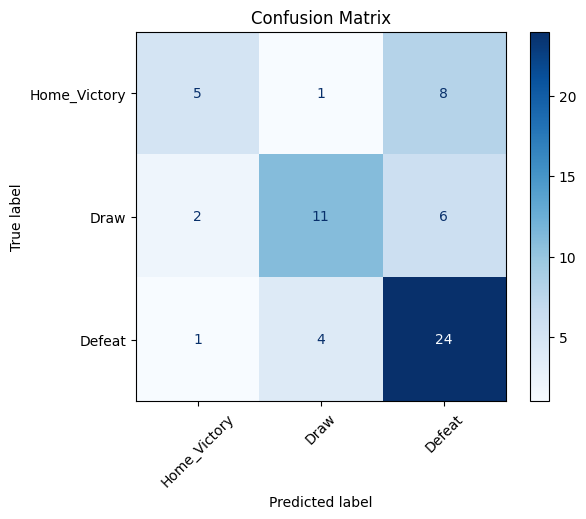

In [32]:
model = RandomForestClassifier()
model.fit(X_train_processed, y_train)

predictions = model.predict(X_test_processed)

print(
    classification_report(
        y_test,          # True labels (strings)
        predictions,          # Predicted labels (strings)
        target_names=['Home_Victory', 'Draw', 'Defeat']  # Optional: ensures consistent order
    )
)

ConfusionMatrixDisplay.from_predictions(
    y_test,
    predictions,
    display_labels=['Home_Victory', 'Draw', 'Defeat'],
    cmap='Blues',
    xticks_rotation=45
)
plt.title('Confusion Matrix')
plt.show()

# Gathering some infomation about Teams

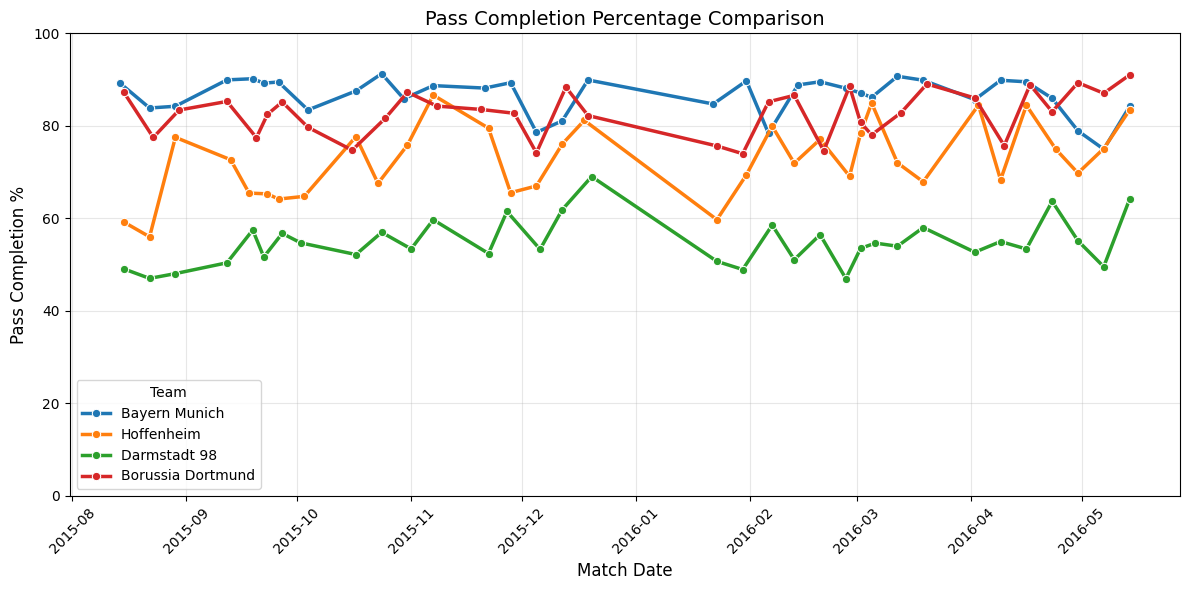

In [8]:
pass_completion_rates = team_stats[['team', 'match_date', 'pass_completion_percentage']]

teams_to_plot = ['Bayern Munich', 'Borussia Dortmund', 'Darmstadt 98', 'Hoffenheim']
multi_team_data = pass_completion_rates[pass_completion_rates['team'].isin(teams_to_plot)]

# Create plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=multi_team_data,
             x='match_date',
             y='pass_completion_percentage',
             hue='team',
             marker='o',
             linewidth=2.5)

plt.title('Pass Completion Percentage Comparison', fontsize=14)
plt.xlabel('Match Date', fontsize=12)
plt.ylabel('Pass Completion %', fontsize=12)
plt.legend(title='Team')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()